In [5]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys; sys.path.append('..')
import pyzx as zx
from fractions import Fraction
%config InlineBackend.figure_format = 'svg'

Available backends: simple, igraph


In [2]:
g = zx.cnots(5, 10)

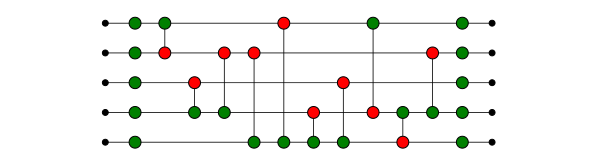

In [3]:
zx.draw(g)

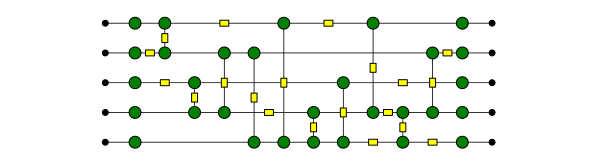

In [4]:
g1 = g.copy()
zx.simplify.to_green(g1)
zx.draw(g1)

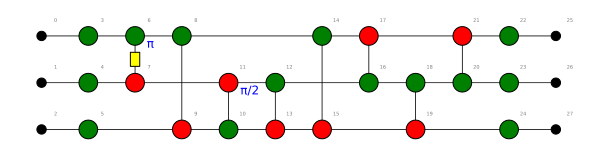

In [9]:
g.add_edge_table({(6,7):(0,1)})
g.set_angle(11,Fraction(1,2))
zx.draw(g,labels=True)

In [10]:
g.get_angle(7)

0

In [9]:
c = {0 : {'a': 0, 'b': 1}}